In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import random
from scipy.stats import t, f, norm

In [15]:
def GenerateUniform(N):
    ksi = np.random.uniform(-1, 1, N)
    return ksi

def GenerateNormal(mean, sigma, n):
    eta = np.random.normal(mean, sigma, n)
    return eta

In [16]:
def GenerateSample(n):
    x = []
    for i in range(n):
        coefs = np.array([3, -2, 1, 1, -1])
        ksi = GenerateUniform(5)
        eta = GenerateNormal(2 + ksi @ coefs, 1.5, 1)
        x.append(np.concatenate((ksi, eta)))
    return np.array(x)

In [17]:
sample = GenerateSample(50)
data = pd.DataFrame(sample, columns = ['x1','x2','x3','x4','x5','etta'])
data.head(6)

,x1,x2,x3,x4,x5,etta
0,0.043251,-0.993840,0.449003,0.312583,-0.669734,4.237631
1,-0.857078,0.399483,-0.040812,0.540946,0.876100,-0.374751
2,-0.499265,-0.452540,0.234011,-0.374821,-0.456122,1.664842
3,-0.333040,-0.051618,-0.001454,0.322310,0.712139,-1.650209
4,0.175984,0.568327,-0.553519,0.340715,-0.554443,1.690759
5,0.789823,-0.048599,-0.272376,0.575609,-0.059920,6.526589


### y = b1 + b2x1 + b3x2 + b4x3 + b5x4 + b6x5

In [18]:
n = 50
p = 6

In [19]:
def PSIFunc(sample):
    n = len(sample)
    return np.concatenate((np.matrix([1] * n).reshape(n, 1), sample[:, :-1]), axis=1)

def FFunc(sample):
    PSI = PSIFunc(sample)
    return PSI.T @ PSI

def BetaFunc(sample):
    Y = sample[:, -1]
    PSI = PSIFunc(sample)
    F = FFunc(sample)
    return np.array(np.linalg.inv(F) @ PSI.T @ Y)[0]

def EFunc(sample):
    Y = sample[:, -1]
    PSI = PSIFunc(sample)
    return np.array(Y - PSI @ BetaFunc(sample))[0]

def RSSFunc(sample):
    e = EFunc(sample)
    return e @ e.T

def TSSFunc(sample):
    Y = sample[:, -1]
    mean = np.mean(Y)
    return np.sum((Y - mean) ** 2)

def R2Func(sample):
    tss = TSSFunc(sample)
    rss = RSSFunc(sample)
    return (tss - rss) / tss

In [20]:
def PrintEq(beta):
    print(f"y = {round(beta[0], 2)} ", end='')
    for i in range(1, len(beta)):
        print(f"{'+' if beta[i] > 0 else '-'} {abs(round(beta[i], 1))}*x{i} ", end='')
    print('+ e')

In [21]:
beta = BetaFunc(sample)
PrintEq(beta)

y = 1.74 + 4.1*x1 - 1.4*x2 + 1.2*x3 + 1.6*x4 - 0.1*x5 + e


## Проверка ну мультиколлинеарность 

In [36]:
def MultCheck(sample):
    wide = np.shape(sample)[1] - 1
    for i in range(wide):
        cur = np.array(sample[:, :-1], copy=True)
        cur[:, i], cur[:, wide - 1] = sample[:, wide - 1], sample[:, i]
        print(R2Func(cur), "< 0.7, => не существенно связано")

In [37]:
MultCheck(sample)

0.1490765494992467 < 0.7, => не существенно связано
0.028322176392003753 < 0.7, => не существенно связано
0.13958829993049246 < 0.7, => не существенно связано
0.07847973119835672 < 0.7, => не существенно связано
0.11287020405477957 < 0.7, => не существенно связано


### Проверка значимости коэффициентов

In [38]:
def Significance(sample):
    deltas = []
    F = FFunc(sample)
    rss = RSSFunc(sample)
    beta = BetaFunc(sample)
    deltas = beta / np.sqrt(rss * np.diag(np.linalg.inv(F)) / 44)
    p_values = 2 * t.sf(np.abs(deltas), 44)
    return p_values

In [39]:
significance = Significance(sample)
print(np.arange(1, 7)[significance < 0.05], 'значимые')

[1 2 3 4 5] значимые


In [40]:
significance

array([1.34992134e-10, 2.65786599e-13, 8.43146888e-04, 3.18307826e-03,
       6.21469224e-05, 8.35224112e-01])

### R2

In [51]:
r2 = R2Func(sample)
print('R2 = ', round(r2, 3))

R2 =  0.757


In [52]:
def R2PVALUE(sample):
    r2 = R2Func(sample)
    n = len(sample)
    p = len(BetaFunc(sample))
    delta_tss = r2 / (1 - r2) * (n - p) / (p - 1) 
    p_value_tss = f.sf(delta_tss, p - 1, n - p)
    return p_value_tss

In [53]:
p_value_tss = R2PVALUE(sample)
if (p_value_tss <= 0.05):
    print('Влияние факторов существенно, p_value =', round(p_value_tss, 5))

Влияние факторов существенно, p_value = 0.0


### Доверительный интервал 

In [54]:
def ConfInterval(sample, psi_x0):
    beta = BetaFunc(sample)
    n = len(sample)
    p = len(beta)
    y_0 = psi_x0 @ beta
    print(y_0)
    kappa = np.sqrt(1 + psi_x0 @ np.linalg.inv(FFunc(sample)) @ psi_x0.T)[0, 0]
    t_0975 = 1.68
    rss = RSSFunc(sample)
    same_part = t_0975 * np.sqrt(rss) * kappa / np.sqrt(n - p )
    left = y_0 - same_part
    right = y_0 + same_part
    return left, right

In [55]:
psi_x0 = np.array([1, 0, 0, 0, 0, 0])
ConfInterval(sample, psi_x0)

1.7413327452781826


(-0.6604158292704527, 4.143081319826818)

### Независимость ошибок измерения 

In [56]:
def Inversions(arr):
    return np.sum([np.sum(arr[i] < arr[:i]) for i in range(len(arr))])

In [57]:
def CheckIndepend(sample):
    e = EFunc(sample)
    I = Inversions(e)
    n = len(sample)
    delta_errors = (I - n * (n - 1) / 4)  / np.sqrt(n ** 3 / 36)
    return 2 * norm.sf(abs(delta_errors), 0, 1)

In [59]:
if CheckIndepend(sample) >= 0.5:
    print(CheckIndepend(sample), "они независимы, и одинаково распределены")

0.581261299930204 они независимы, и одинаково распределены


### Проверка нормальности

In [60]:
from scipy.stats import norm 
from scipy.stats import moment

def F(sample, x):
    n = len(sample)
    return np.sum(sample < x) / n

def Sigma(sample):
    n = len(sample)
    return np.sqrt(n / (n - 1) * np.var(sample))

def KolmogorovDelta(sample):
    res = -10
    sigma = Sigma(sample)
    for i in range(len(sample) - 1):
        f = norm.cdf(sample[i], 0, sigma)
        F_i = F(sample, sample[i])
        F_i_1 = F(sample, sample[i + 1])
        res = max(res, abs(f - F_i), abs(f - F_i_1))
    return res * len(sample) ** 0.5


In [61]:
def ModulateNormal(mean, sigma, n):
    s = np.random.normal(mean, sigma, n)
    s = np.sort(s)
    return s

def GaussGenerateSamples(mean, sigma, n, N = 1000):
    return [ModulateNormal(mean, sigma, n) for _ in range(N)]

def ParametricBootstrapForKolmogorov(xn):
    mean = 0
    n = len(xn)
    sigma = Sigma(xn)
    N = 10000
    generated =  GaussGenerateSamples(0, sigma, n, N)
    
    delta_wave = KolmogorovDelta(xn)
    print('delta_wave = ', delta_wave)
    
    delts = np.array([])
    for cur_sample in generated:
        d = KolmogorovDelta(cur_sample)
        delts = np.append(delts, d)
        
    return len(delts[delts > delta_wave]) / N

In [62]:
e_s = np.sort(EFunc(sample))
ParametricBootstrapForKolmogorov(e_s)

delta_wave =  0.8033059379671899


0.4419

### не оснований отвергать что N(0, sigma ** 2)

### boxplot

In [64]:
import seaborn as sns

def Median(array):
    N = len(array)
    return np.median(array)

def Quartiles(array):
    N = len(array)
    if (N % 2 == 0):
        q1 = Median(array[0 : N//2])
        q2 = Median(array[N//2 : N])
    else:
        q1 = Median(array[0 : N//2])
        q2 = Median(array[N//2 + 1 : N])
    return q1, q2
    
def Epsilon(array):
    q1, q2 = Quartiles(array)
    return q2 - q1
    
def Boxplot(array):
    cur_arr = np.array(array, copy = 1)
    cur_arr = np.sort(cur_arr)
    sns.boxplot(x=cur_arr, whis=Epsilon(cur_arr)*1.5) #длина усиков = 1.5EPSILON

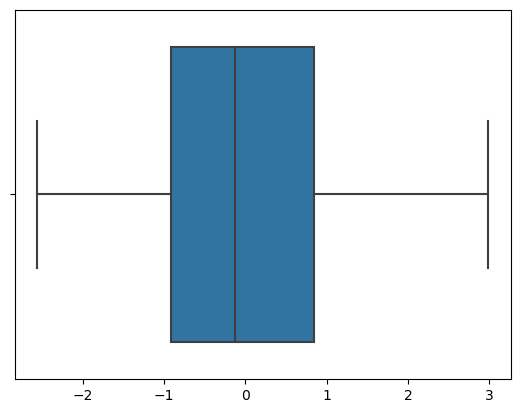

In [65]:
Boxplot(e_s)

### cross check

In [66]:
def CVSSFunc(sample):
    s = 0
    for i in range(len(sample)):
        cur_sample = np.delete(sample, i, 0)
        beta = BetaFunc(cur_sample)
        psi0 = np.concatenate(([1] ,sample[i, :-1]))
        d = sample[i, -1] - psi0 @ beta
        s += d ** 2
    return s

def R2CVSSFunc(sample):
    cvss = CVSSFunc(sample)
    tss = TSSFunc(sample)
    return (tss - cvss) / tss

In [98]:
R2CVSSFunc(sample) #предсказывает нормально

0.6899110343789183

In [99]:
CVSSFunc(sample)

112.44235032570288

### адекватность 

In [69]:
def OnOnePoint(ksi, n):
    coefs = np.array([3, -2, 1, 1, -1])
    eta =  [ ]
    for i in range(n):
        eta.append(GenerateNormal(2 + ksi @ coefs, 1.5, 1)[0])
    return eta

def S2(x):
    mean = np.mean(x)
    return np.sum((x - mean)**2) / ( len(x) - 1) 

In [70]:
l = 5
measurements = OnOnePoint(np.array([0.5, 0.5, 0.5, 0.5, 0.5]), l)
s2 = S2(measurements)
delta_adecv = RSSFunc(sample) / (n - p) / s2
f.sf(delta_adecv, n - p, l - 1)

0.6486636293143653

In [100]:
#модель адекватна, p > 0.05

### удаление

In [116]:
def MinIndex(arr):
    return np.where(arr == np.min(arr))[0][0]

def MaxIndex(arr):
    return np.where(arr == np.max(arr))[0][0]

In [117]:
significance = Significance(sample)
significance

array([1.34992134e-10, 2.65786599e-13, 8.43146888e-04, 3.18307826e-03,
       6.21469224e-05, 8.35224112e-01])

In [118]:
new = np.delete(sample, MaxIndex(significance) - 1, 1)

In [119]:
Significance(new)

array([1.15053042e-10, 2.54323857e-13, 8.55708589e-04, 1.73906052e-03,
       6.33129628e-05])

In [120]:
R2Func(new)

0.7570612060375922

In [121]:
R2PVALUE(new)

2.690101753773574e-13

### сравнение 

In [108]:
def Compare(sample):
    new = np.delete(sample, MaxIndex(significance) - 1, 1)
    rss0 = RSSFunc(new)
    rss1 = RSSFunc(sample)
    beta = BetaFunc(sample)
    p1 = len(beta)
    p0 = p1 - 1
    n = len(sample)
    delta = (rss0 - rss1) / rss1 * (n - p1) / (p1 - p0)
    return f.sf(delta, p1 - p0, n - p1)

In [110]:
Compare(sample) # H0: bi = 0 

0.8352241123160433

In [111]:
def BootstrapGenerate(data, n_bootstrap_samples=1000):
    return [np.random.choice(data, size=len(data), replace=True) for _ in range(n_bootstrap_samples)]

In [112]:
def NonParamBootstrap(sample):
    index = np.arange(50)
    new = np.delete(sample, MaxIndex(Significance(sample)) - 1, 1)
    var_num = MaxIndex(Significance(sample)) - 1
    deltas = np.array([])
    botstrap_generated = BootstrapGenerate(np.arange(0, 50))
    rss1 = RSSFunc(sample)
    rss0 = RSSFunc(new)
    beta = BetaFunc(sample)
    p1 = len(beta)
    p0 = p1 - 1
    n = len(sample)
    for cur_indexes in botstrap_generated:
        cur_sample_deleted = new[cur_indexes]
        cur_sample = sample[cur_indexes]
        cur_rss0 = RSSFunc(cur_sample_deleted)
        cur_rss1 = RSSFunc(cur_sample)
        d = (cur_rss0 - cur_rss1) / rss1 * (n - p1) / (p1 - p0)
        deltas = np.append(d, deltas)
    delt = (rss0 - rss1) / rss1 * (n - p1) / (p1 - p0)
    return np.sum(deltas > delt) / 1000

In [113]:
NonParamBootstrap(sample)

0.805

In [122]:
s = np.array([[1, 5],[2, 1], [3, -1], [4, 0], [5, -3]])

In [84]:
tfcp = np.array([[19, 9, 6], [22, 15, 7], [14, 10, 5], [17, 3, 3], [21, 6, 6], [24, 8, 8], [23, 13, 8], [22, 4, 5], [15, 3, 6], [24, 10, 8], [15, 9, 4],  [18, 3, 3], [15, 13, 6], [20, 3, 5], [21, 16, 5]])

RSSFunc(tfcp)

18.538637260984828

In [85]:
BetaFunc(tfcp)

array([-0.30410627,  0.25227029,  0.13122568])

In [86]:
R2Func(tfcp)

0.5034293590807635

In [87]:
EFunc(tfcp)

array([ 0.32993965, -0.21422528,  0.46006543, -1.37816572,  0.21907609,
        1.19981386,  0.79595578, -0.77074285,  2.12637487,  0.93736251,
       -0.66097919, -1.63043601,  0.81411811, -0.13497659, -2.09318066])

In [88]:
MultCheck(tfcp)

0.04165840825960838 < 0.7, => не существенно связано
0.041658408259608364 < 0.7, => не существенно связано


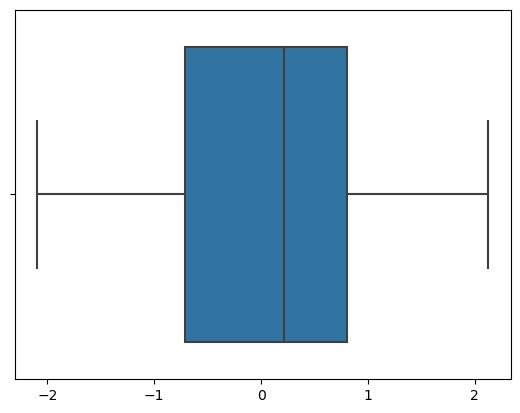

In [89]:
Boxplot(EFunc(tfcp))

In [90]:
e_t = EFunc(tfcp)
cvss_t = CVSSFunc(tfcp)
cvss_t

30.91694428055767

In [91]:
R2CVSSFunc(tfcp)

0.17186756391363378

In [92]:
ConfInterval(tfcp, np.array([1, 15, 8]))

4.5297535111963265


(2.2614565281733845, 6.798050494219268)

In [93]:
ParametricBootstrapForKolmogorov(np.sort(e_t))

delta_wave =  0.42148685598440716


0.9737

In [123]:
ParametricBootstrapForKolmogorov(eS)

delta_wave =  0.42148685598440716


0.9726